In [1]:
# Libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas
import pickle

# Modelling Libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder, KBinsDiscretizer
from sklearn.naive_bayes import CategoricalNB, GaussianNB, BernoulliNB
from sklearn.metrics import f1_score, confusion_matrix,ConfusionMatrixDisplay

In [2]:
# Import csv and convert to pandas
filename = 'Everything_12_1/12_1_Ordered_Merged_Data.csv'
df = pandas.read_csv(filename)

print(df.columns)
print(len(df))
print(np.unique(df['hosp_yn'], return_counts = True))

Index(['location', 'month', 'age_group', 'sex', 'race', 'ethnicity',
       'current_status', 'symptom_status', 'average_value', 'hosp_yn'],
      dtype='object')
294108
(array(['Missing', 'No', 'Yes'], dtype=object), array([166272, 115813,  12023]))


In [3]:
# # Remove all Missing values from this 
df = df.replace('Missing', np.nan)
df = df.dropna(axis=0)

In [4]:
# Assign Labels + SPlit INputs into continuous and categorical
Y = df['hosp_yn']
X_cont = pandas.DataFrame(df['average_value'])
X = df.drop(['hosp_yn', 'average_value'], axis = 1)

In [5]:
# Data pre-processing - One-Hot Encoding - Categorical input params
ohe = OneHotEncoder()
ohe.fit(X)

# Returns CSR Matrix
X_enc = ohe.transform(X)

# print(X_enc.shape)
# print(ohe.get_feature_names_out())

# # Save encode to Pickle
# with open('catX_Enc.pkl', 'wb') as f:
#     pickle.dump(ohe, f)

In [6]:
# Pre-Process the Continuous Vars - MinMaxScaler and Bucketize
# scaler = MinMaxScaler()
# scaler.fit(X_cont)
# X_cont['Val_Norm'] = scaler.transform(X_cont)

# Save the MinMaxScaler
# with open('minmaxscaler.pkl' 'wb') as f:
#     pickle.dump(scaler, f)


# Add Bucketization
# Bin effective R data into 50 bins - perhaps run sensitivity study
est = KBinsDiscretizer(n_bins = 10, encode = 'onehot', strategy = 'uniform')
est.fit(pandas.DataFrame(X_cont))

# transform value
tDF = est.transform(pandas.DataFrame(X_cont))
print(tDF.shape)
print(est.get_feature_names_out())
bin_edges = est.bin_edges_


# Save Discretization
# with open('binDiscrete10.pkl', 'wb') as f:
#     pickle.dump(est, f)

# # Extract start and end values for bins
# for i, edges in enumerate(bin_edges):
#     print(f"Feature {i+1}:")
#     for j in range(len(edges) - 1):
#         print(f"  Bin {j+1}: Start = {edges[j]}, End = {edges[j+1]}")

(127836, 10)
['average_value_0.0' 'average_value_1.0' 'average_value_2.0'
 'average_value_3.0' 'average_value_4.0' 'average_value_5.0'
 'average_value_6.0' 'average_value_7.0' 'average_value_8.0'
 'average_value_9.0']


/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


In [7]:
# Replace the missing label with No
# Y = Y.replace('Missing', 'No')

# encode the Y label
le = LabelEncoder()
le.fit(Y)
Y_enc = le.transform(Y)
print(Y_enc)
print(le.inverse_transform(Y_enc))

# Save Label Encoder
# with open('labelEncN_Y.pkl', 'wb') as f:
#     pickle.dump(le, f)

[0 1 0 ... 0 0 0]
['No' 'Yes' 'No' ... 'No' 'No' 'No']


In [8]:
# Compile all the elements into a single dataframe for train-test split
X_processed = pandas.DataFrame(X_enc.toarray(), columns = ohe.get_feature_names_out())
# Add the continuous Bins - 
df_cont = pandas.DataFrame(tDF.toarray(), columns = est.get_feature_names_out())

# combine the two dataframes together in the column axis
X_processed = pandas.concat([X_processed, df_cont], axis = 1)
                           
# Split Data into train test
x_train, x_test, y_train, y_test = train_test_split(X_processed, Y_enc, stratify = Y_enc, random_state = 42)

[0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7  0.75
 0.8  0.85 0.9  0.95]
[0.25621025 0.18943307]
[0.42574899 0.20812863]
[0.57704265 0.23441484]
[0.67877183 0.26089651]
[0.73664171 0.28285182]
[0.77794048 0.30224872]
[0.80679832 0.3199208 ]
[0.83494956 0.33891934]
[0.8523998  0.35293127]
[0.87278474 0.37179487]
[0.88516436 0.38382631]
[0.89991236 0.40061229]
[0.91008341 0.40661039]
[0.91810875 0.41142564]
[0.92534894 0.40953443]
[0.93534027 0.39644301]
[0.94513022 0.34520437]
[0.95121587 0.18045113]


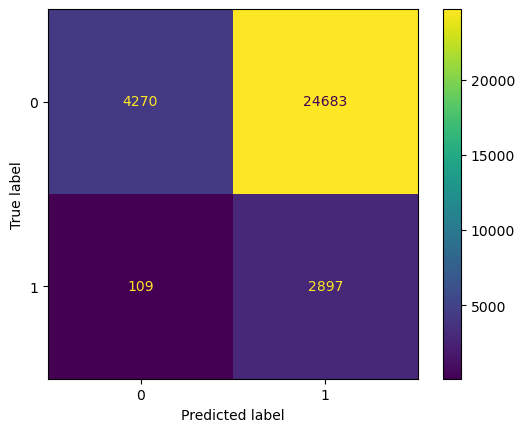

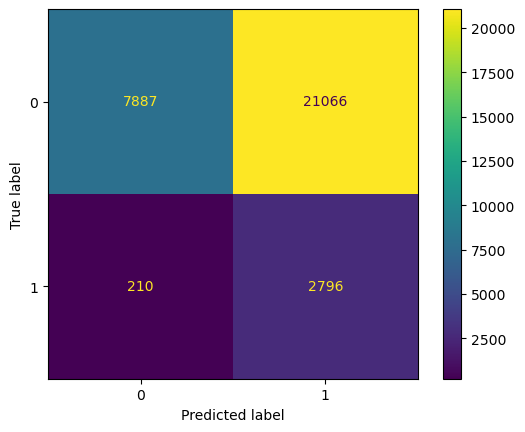

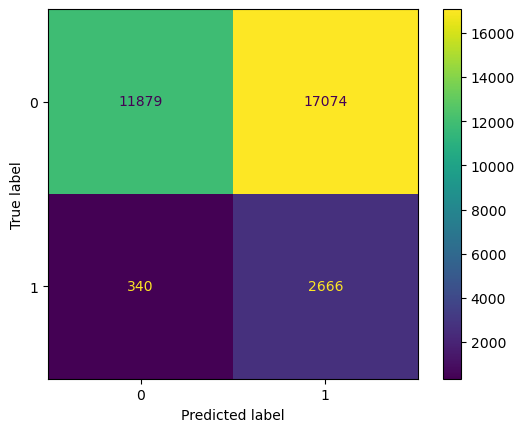

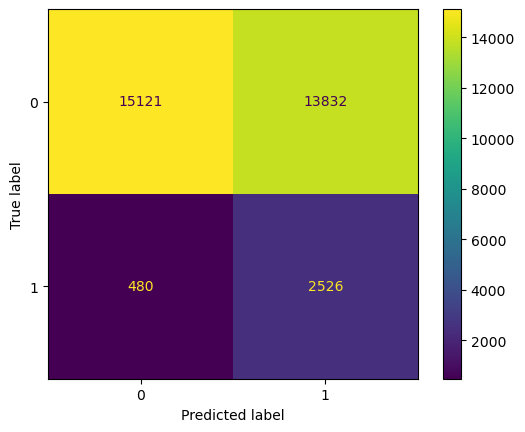

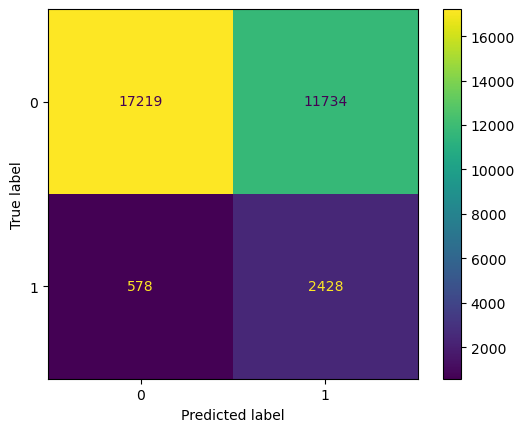

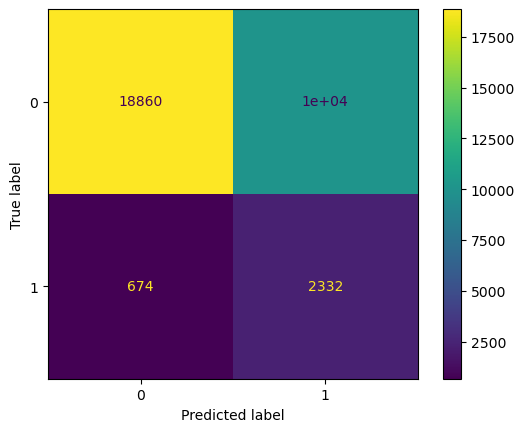

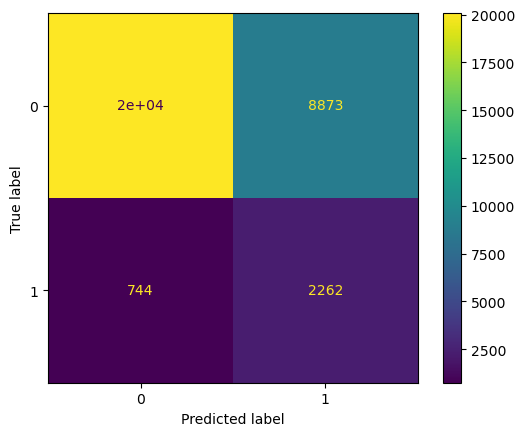

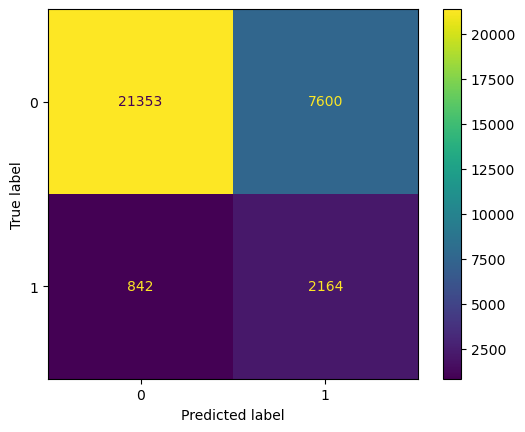

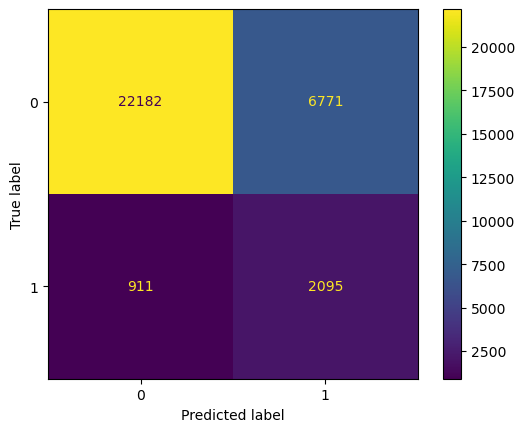

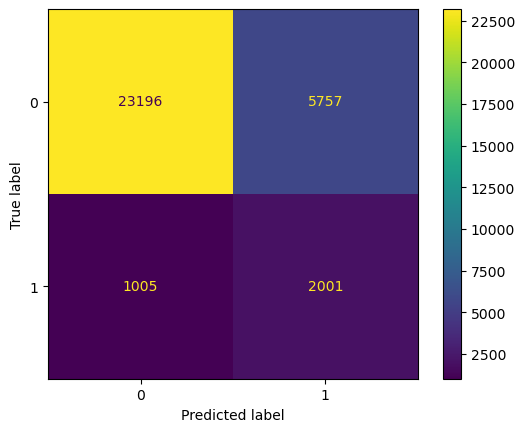

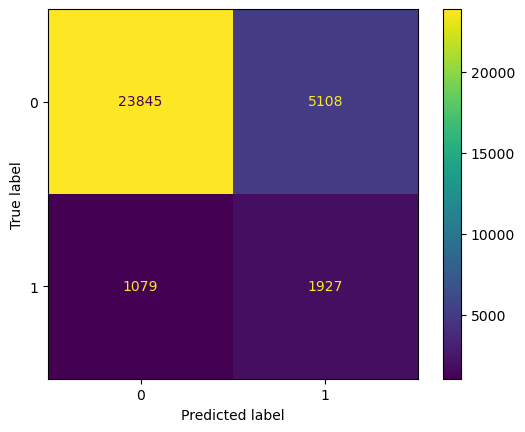

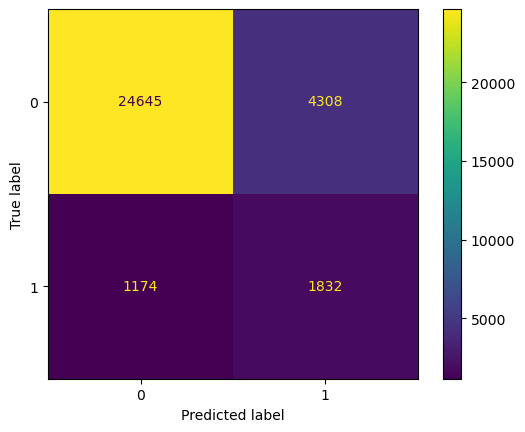

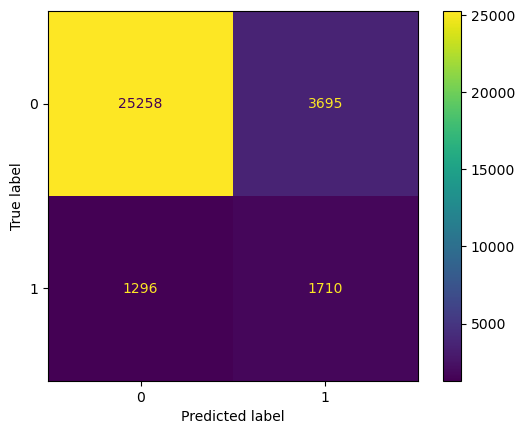

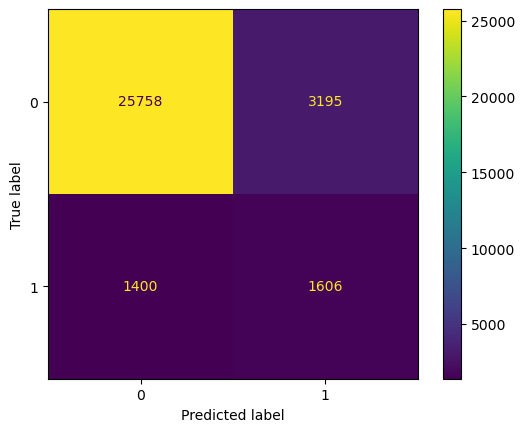

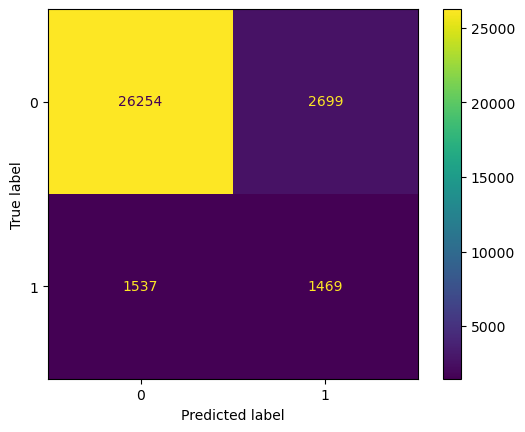

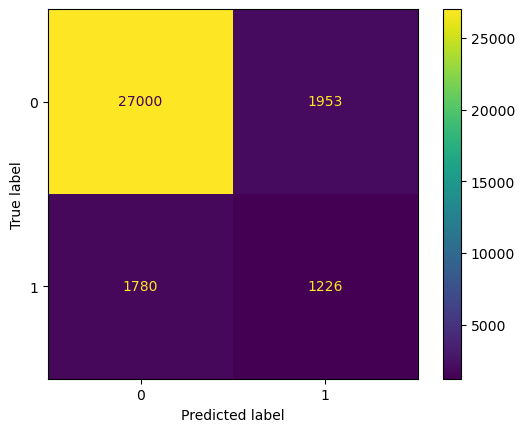

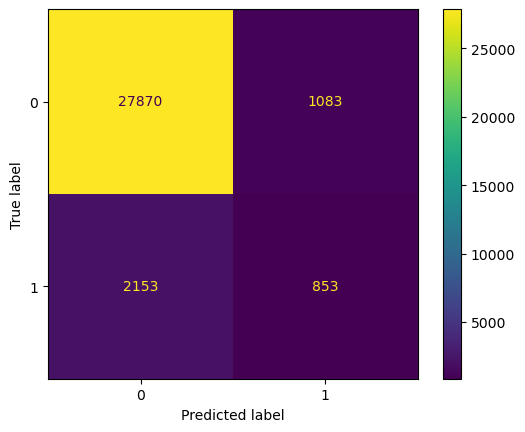

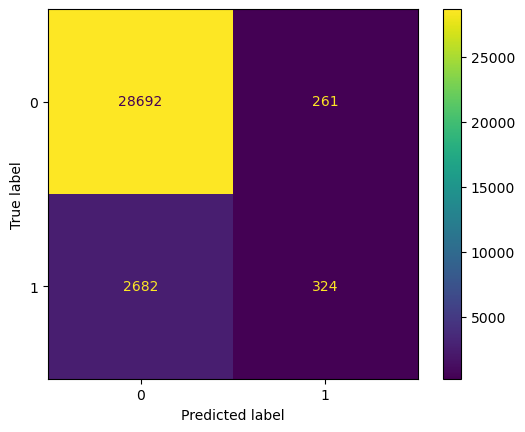

In [9]:
# SkLearn Naive Bayes Classifier Library
# Run a range of priors to see whether
prior1arr = []
score0Arr = []
score1Arr = []
priorRange = np.arange(.10,1,.05)
print(priorRange)
for i in range(len(priorRange)):
    # define the class prior array
    classPrior = [priorRange[i], 1-priorRange[i]]
    prior1arr.append(1-priorRange[i])
    clf = BernoulliNB(fit_prior = False, class_prior = classPrior)
    model = clf.fit(x_train, y_train)
    pred_y = model.predict(x_test)
    
    # Compute F1 Score
    f1 = f1_score(y_test, pred_y, average = None)

    print(f1)
    score0Arr.append(f1[0])
    score1Arr.append(f1[1])

    # Conf Matrix
    ConfusionMatrixDisplay.from_estimator(model, x_test, y_test)


<Axes: >

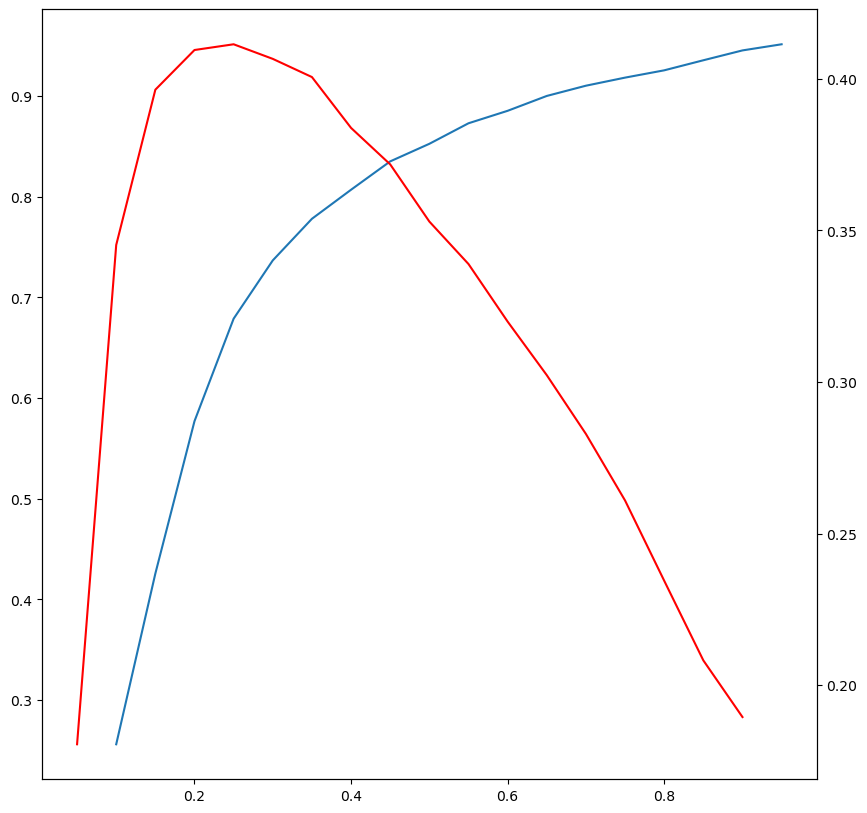

In [10]:
# PLot the progression of the f1_scores
fig, ax = plt.subplots(figsize = (10,10))
ax = sns.lineplot(x = priorRange, y = score0Arr)
ax2 = ax.twinx()
sns.lineplot(x = prior1arr, y = score1Arr, color = 'r')